<h1>Predicting Diabetes: A Machine Learning Approach</h1>

<div style="background-color:rgba(120,120,120,0.2);padding:15px;border-radius:10px;">
<div>Diabetes, a chronic medical condition characterized by elevated blood sugar levels, has become a global health concern with a significant impact on individuals and healthcare systems. According to the World Health Organization (WHO), an estimated 422 million people worldwide were living with diabetes in 2014, and the prevalence is expected to rise.</div>
</div>

<div style="background-color:rgba(120,120,120,0.2);padding:15px;border-radius:10px;">
<div>This Jupyter Notebook aims to explore and predict diabetes using a machine learning model. The dataset used for this analysis contains various health metrics and lifestyle factors. Through exploratory data analysis (EDA), we will get insights about the relationships between different features and their influence on the likelihood of diabetes. After generating the model, it will be deployed as a web app to predict the probability of a user having diabetes.</div>
</div>

<h1 style="font-size:20px;">About the dataset:</h1>
<ul>
    <li>
        <code>gender</code>: Gender refers to the biological sex of the individual, which can have an impact on their susceptibility to diabetes. There are three categories in it male ,female and other.
    </li>
    <br>
    <li>
        <code>age</code>: Age is an important factor as diabetes is more commonly diagnosed in older adults.Age ranges from 0-80 in our dataset.
    </li>
    <br>
    <li>
        <code>hypertension</code>: Hypertension is a medical condition in which the blood pressure in the arteries is persistently elevated. It has values a 0 or 1 where 0 indicates they don’t have hypertension and for 1 it means they have hypertension.
    </li>
    <br>
    <li>
        <code>heart_disease</code>: Heart disease is another medical condition that is associated with an increased risk of developing diabetes. It has values a 0 or 1 where 0 indicates they don’t have heart disease and for 1 it means they have heart disease.
    </li>
    <br>
    <li>
        <code>smoking_history</code>: Smoking history is also considered a risk factor for diabetes and can exacerbate the complications associated with diabetes.In our dataset we have 5 categories i.e not current,former,No Info,current,never and ever.
    </li>
    <br>
    <li>
        <code>bmi</code>: BMI (Body Mass Index) is a measure of body fat based on weight and height. Higher BMI values are linked to a higher risk of diabetes. The range of BMI in the dataset is from 10.16 to 71.55. BMI less than 18.5 is underweight, 18.5-24.9 is normal, 25-29.9 is overweight, and 30 or more is obese.
    </li>
    <br>
    <li>
        <code>HbA1c_level</code>: HbA1c (Hemoglobin A1c) level is a measure of a person's average blood sugar level over the past 2-3 months. Higher levels indicate a greater risk of developing diabetes. Mostly more than 6.5% of HbA1c Level indicates diabetes.
    </li>
    <br>
    <li>
        <code>blood_glucose_level</code>: Blood glucose level refers to the amount of glucose in the bloodstream at a given time. High blood glucose levels are a key indicator of diabetes.
    </li>
    <br>
    <li>
        <code>diabetes</code>: Diabetes is the target variable being predicted, with values of 1 indicating the presence of diabetes and 0 indicating the absence of diabetes.
    </li>
</ul>
<p>The dataset can be found at <a href='https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset'>https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset</a></p>
<hr>

In [ ]:
!pip install mlflow

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import umap
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import mlflow
import optuna

# Seed for random number generation
SEED = 101

plt.style.use('ggplot')

<h1 id = "EDA">Exploratory Data Analysis</h1>

In [3]:
# Reading the data
df = pd.read_csv('diabetes_prediction_dataset.csv')

In [4]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [5]:
df.shape

(100000, 9)

<div>There are 100000 rows and 9 columns</div>

In [6]:
# Categorical features
cat_features = ['gender','smoking_history']

# Binary features
bin_features = ['hypertension','heart_disease']

# Numerical features
num_features = df.drop(columns=cat_features + bin_features + ['diabetes']).columns.tolist()


# Target variable
target = 'diabetes'

print(cat_features,'\n', num_features, '\n', '\n', bin_features, target)

['gender', 'smoking_history'] 
 ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'] 
 
 ['hypertension', 'heart_disease'] diabetes


<h2>Checking missing data and duplicated values</h2>

In [7]:
# Checking missind data per column
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

<div>None of the columns have missing data</div>
<div>The command above just showed that there are no NaN values in the dataset. We saw in the <code>df.head()</code> command that the <code>smoking_history</code> column has a <i>No Info</i> value. This will be addressed later</div>

<h2>Checking duplicated data</h2>

In [8]:
# Counting how many rows are duplicated
df.duplicated().sum()

3854

In [9]:
# Getting the dataframe without duplicated rows
df = df.drop_duplicates()

In [10]:
# The new dataframe shape
df.shape

(96146, 9)

<h2>Checking the unique values for the columns</h2>

In [11]:
# Unique values for gender
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [12]:
# Unique values for smoking_history
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

<div>We have two categories that must be dealt with: <code>Other</code> for <code>gender</code> and <code>No Info</code> for <code>smoking_history</code></div>
<div>In order to take a decision, it is necessary to calculate the proportion of this values in their respective feature</div>

In [13]:
# Checking the proportion of the category 'Other' for the gender feature
df['gender'].value_counts(normalize=True)

gender
Female    0.584122
Male      0.415691
Other     0.000187
Name: proportion, dtype: float64

<div>The category <code>Other</code> represents only 0.0187% of the values. Since it is a very small part, it will be dropped</div>

In [14]:
# Dropping rows with 'Other'
df = df.query("gender != 'Other'").reset_index(drop=True)

In [15]:
# Checking the proportion of the category 'No Info' for the smoking_history feature
df['smoking_history'].value_counts(normalize=True)

smoking_history
never          0.357804
No Info        0.342054
former         0.096736
current        0.095675
not current    0.066151
ever           0.041580
Name: proportion, dtype: float64

<div>The category <code>No Info</code> represents 34.2% of the <code>smoking_history</code> values. Since it is a large part of the instances for the column <code>smoking_history</code>, assigning a value to the category might have a big impact on the results. It will be considered as a valid category


<h2>Checking the distribution of the target and the features</h2>

<h3>Categorical Features</h3>

In [16]:
# Checking the proportion of diabetes
df['diabetes'].value_counts(normalize=True)

diabetes
0    0.911763
1    0.088237
Name: proportion, dtype: float64

<Axes: xlabel='diabetes', ylabel='count'>

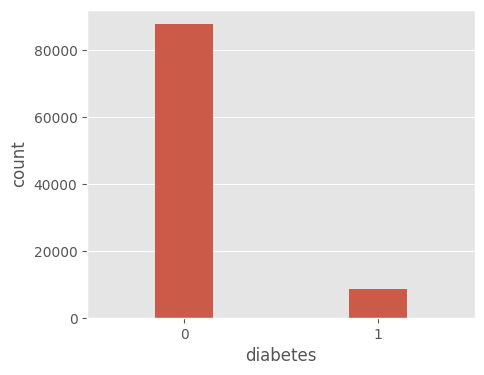

In [17]:
# Plotting diabetes distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df,x='diabetes',width=0.3)

<div>We can see that the dataset is unbalanced, with diabetes representing 8.8% of the instances. This unbalance can cause problems when developing the machine learning model, as the model might learn just to predict the majority class. The issue of imbalance will be addressed during the model development phase.</div>

<h2>Feature <code>gender</code><h2>

In [18]:
# Proportion for Male and Female
df['gender'].value_counts(normalize=True)

gender
Female    0.584231
Male      0.415769
Name: proportion, dtype: float64

In [19]:
# Checking the diabetes for gender
df[['gender','diabetes']].groupby(by='gender').agg(['mean','count'])

diabetes       
            mean  count
gender                 
Female  0.079183  56161
Male    0.100958  39967

<Axes: xlabel='gender', ylabel='count'>

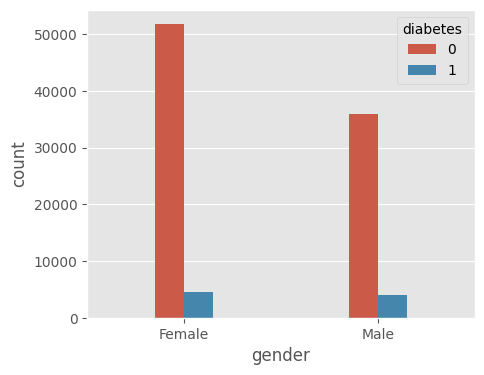

In [20]:
# Plotting gender distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df,x='gender',width=0.3, hue='diabetes')

<div>Diabetes occurrence was higher among <i>Males</i> (10%) when compared with <i>Females</i> (7%)</div>

<h2>Feature <code>hypertension</code><h2>

In [21]:
# Proportion for hypertension
df['hypertension'].value_counts(normalize=True)

hypertension
0    0.922385
1    0.077615
Name: proportion, dtype: float64

In [22]:
# Checking the diabetes mean and count for hypertension
df[['hypertension','diabetes']].groupby(by='hypertension').agg(['mean','count'])

diabetes       
                  mean  count
hypertension                 
0             0.072135  88667
1             0.279587   7461

<Axes: xlabel='hypertension', ylabel='count'>

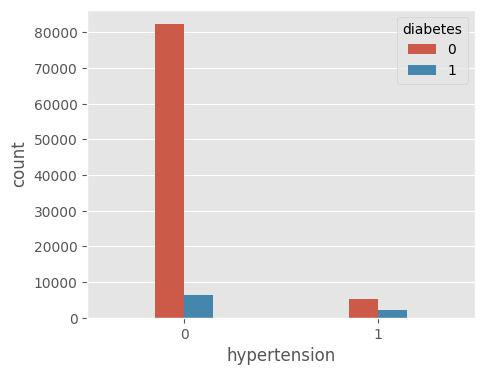

In [23]:
# Plotting hypertension distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df,x='hypertension',width=0.3, hue='diabetes')

<div>Diabetes occurrence was higher among people with <code>hypertension</code> (28%) when compared with people without <code>hypertension</code> (7%)</div>

<h2>Feature <code>heart_disease</code><h2>

In [24]:
# Proportion for heart_disease
df['heart_disease'].value_counts(normalize=True)

heart_disease
0    0.95919
1    0.04081
Name: proportion, dtype: float64

In [25]:
# Checking the diabetes mean and count for heart_disease
df[['heart_disease','diabetes']].groupby(by='heart_disease').agg(['mean','count'])

diabetes       
                   mean  count
heart_disease                 
0              0.078250  92205
1              0.322967   3923

<Axes: xlabel='heart_disease', ylabel='count'>

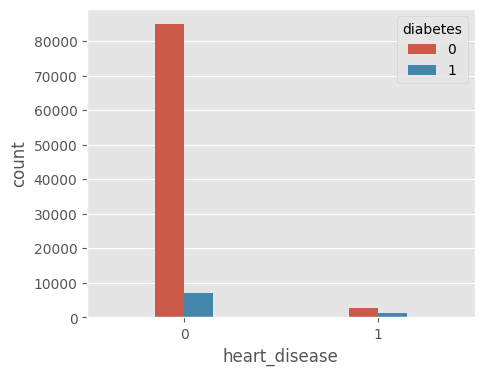

In [26]:
# Plotting hypertension distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df,x='heart_disease',width=0.3, hue='diabetes')

<div>Diabetes occurrence was higher among people with <code>heart_disease</code> (32%) when compared with people without <code>heart_disease</code> (7.8%)</div>

<h2>Feature <code>smoking_history</code><h2>

In [27]:
# Proportion for smoking_history
df['smoking_history'].value_counts(normalize=True)

smoking_history
never          0.357804
No Info        0.342054
former         0.096736
current        0.095675
not current    0.066151
ever           0.041580
Name: proportion, dtype: float64

In [28]:
# Checking the diabetes mean and count for smoking_history
df[['smoking_history','diabetes']].groupby(by='smoking_history').agg(['mean','count'])

diabetes       
                     mean  count
smoking_history                 
No Info          0.043946  32881
current          0.103077   9197
ever             0.118089   3997
former           0.170986   9299
never            0.097020  34395
not current      0.108508   6359

<Axes: xlabel='smoking_history', ylabel='count'>

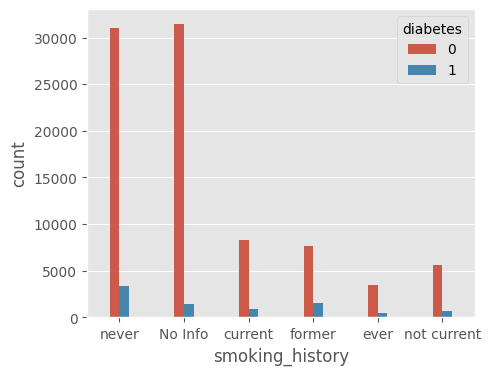

In [29]:
# Plotting smoking_history distribution
plt.figure(figsize=(5,4))
sns.countplot(data=df,x='smoking_history',width=0.3, hue='diabetes')

<div>
The cateogry <code>No Info</code> had the lowest occurrence of diabetes (4.3%). This shows that assigning this category to other class among the others could cause a big change on the diabetes prediction. Former smokers were the ones with higher occurrence of diabetes (17%)
</div>

<h3>Numerical Features</h3>

<h2>Feature <code>age</code></h2>

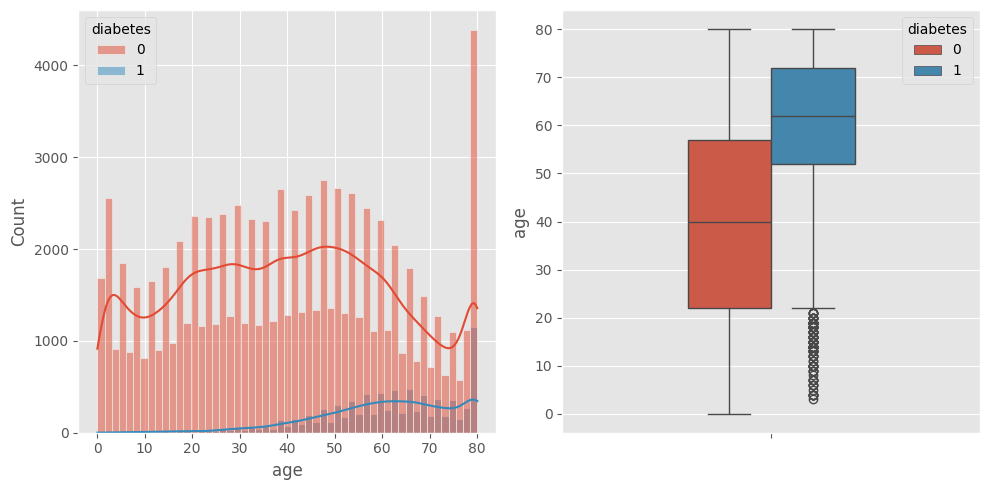

In [30]:
# Plotting age distribution
fig, ax = plt.subplots(figsize=(10,5),nrows=1, ncols=2)
sns.histplot(data=df,x='age', hue='diabetes',ax=ax[0],kde=True)
sns.boxplot(data=df, y='age', hue='diabetes', ax=ax[1], width=0.4)
plt.tight_layout()
plt.show()

<div>The boxplot shows us that the people with diabetes have a median <code>age</code> higher than those without diabetes and the interquantile distance for is narrower for people with diabetes</div>

<h2>Feature <code>bmi</code></h2>

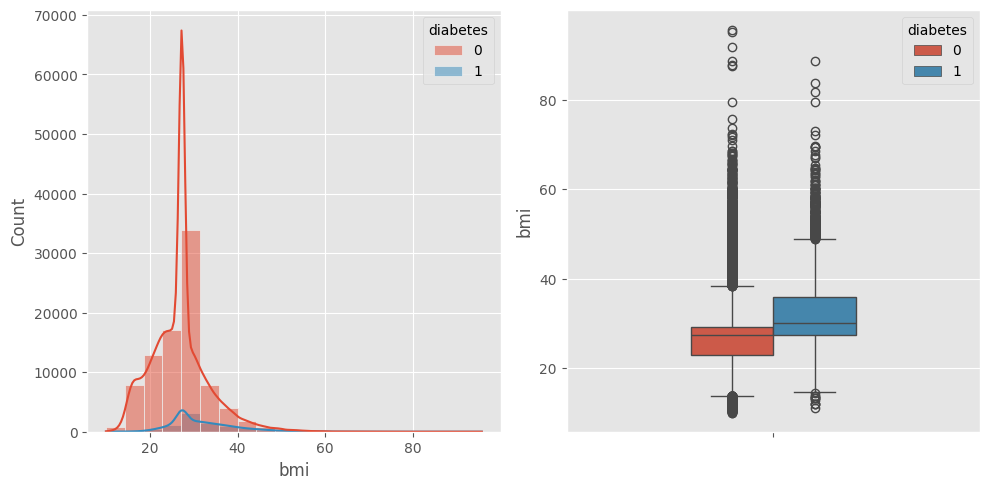

In [31]:
# Plotting bmi distribution
fig, ax = plt.subplots(figsize=(10,5),nrows=1, ncols=2)
sns.histplot(data=df,x='bmi', hue='diabetes',ax=ax[0],kde=True,bins=20)
sns.boxplot(data=df, y='bmi', hue='diabetes', ax=ax[1], width=0.4)
plt.tight_layout()
plt.show()

<div>The boxplot shows us that the people with diabetes have a median <code>bmi</code> higher than those without diabetes.</div>

<h2>Feature <code>blood_glucose_level</code></h2>

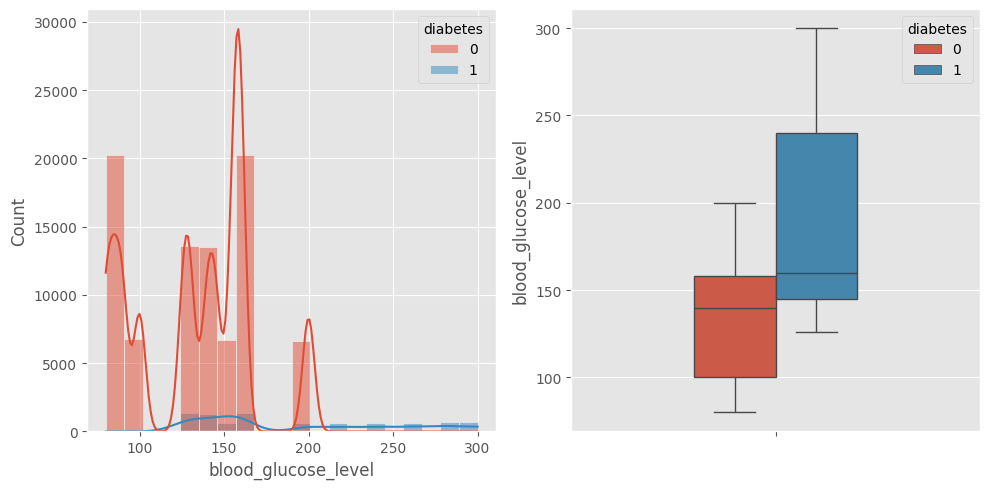

In [32]:
# Plotting blood_glucose_level distribution
fig, ax = plt.subplots(figsize=(10,5),nrows=1, ncols=2)
sns.histplot(data=df,x='blood_glucose_level', hue='diabetes',ax=ax[0],kde=True,bins=20)
sns.boxplot(data=df, y='blood_glucose_level', hue='diabetes', ax=ax[1], width=0.4)
plt.tight_layout()
plt.show()

<div>The boxplot shows us that the people with diabetes have a median <code>blood_glucose_level</code> higher than those without diabetes.</div>
<div>It's also interesting to note that nobody from the non-diabetic group had <code>blood_glucose_level</code> higher than 200 .</div>

<h2>Feature <code>HbA1c_level</code></h2>

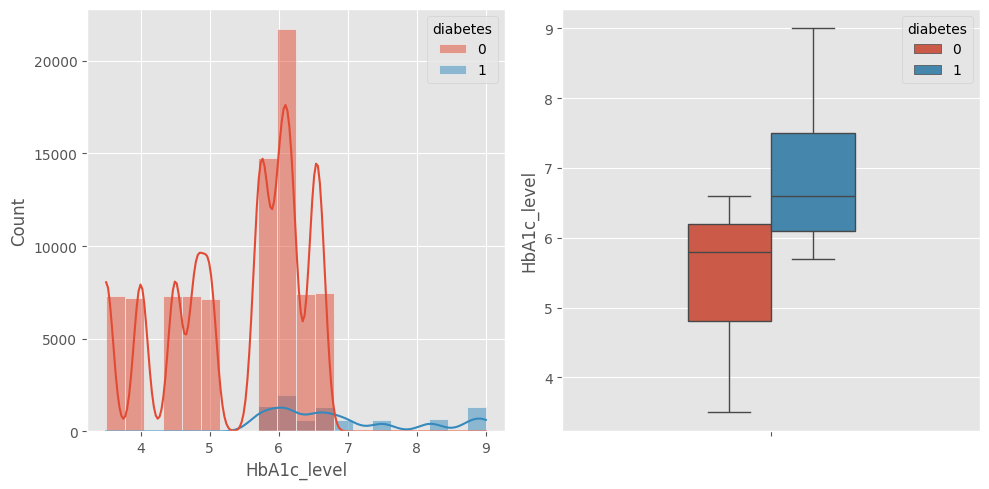

In [33]:
# Plotting blood_glucose_level distribution
fig, ax = plt.subplots(figsize=(10,5),nrows=1, ncols=2)
sns.histplot(data=df,x='HbA1c_level', hue='diabetes',ax=ax[0],kde=True,bins=20)
sns.boxplot(data=df, y='HbA1c_level', hue='diabetes', ax=ax[1], width=0.4)
plt.tight_layout()
plt.show()

<div>The boxplot shows us that the people with diabetes have a median <code>HbA1c_level</code> higher than those without diabetes.</div>
<div>It's interesting to note that nobody from the non-diabetic group had an <code>HbA1c_level</code> higher than approximately 7.</div>

<div>The features related to glucose,<code>blood_glucose_level</code> and <code>HbA1c_level</code>, showed the highest separation between people regarding diabetes. This makes sense, given that diabetes is related to abnormal glucose levels in the bloodstream.</div>

<div>The only feature that showed potential outliers was <code>bmi</code>. But the values represented as dots in the boxplot are possible to happen and should not be considered as outliers.</div>
<hr>

<h2>Correlation Matrix</h2>

In [40]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [35]:
# Dataframe with numerical features
df_num_features = df[num_features + ['diabetes']]

# Dataframe with binary features
df_bin_features = df[bin_features]

# Using pandas get_dummies method for the categorical variables
df_cat_features_encoded = pd.concat([pd.get_dummies(df[cat_feature],prefix=cat_feature) for cat_feature in df.drop(columns=num_features+bin_features+['diabetes']).columns.tolist()],axis=1)

# Concatenating all dataframes
df_all_features = pd.concat([df_num_features, df_bin_features, df_cat_features_encoded], axis=1)

df_all_features.head()

,age,bmi,HbA1c_level,blood_glucose_level,diabetes,hypertension,heart_disease,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,25.19,6.6,140,0,0,1,True,False,False,False,False,False,True,False
1,54.0,27.32,6.6,80,0,0,0,True,False,True,False,False,False,False,False
2,28.0,27.32,5.7,158,0,0,0,False,True,False,False,False,False,True,False
3,36.0,23.45,5.0,155,0,0,0,True,False,False,True,False,False,False,False
4,76.0,20.14,4.8,155,0,1,1,False,True,False,True,False,False,False,False


<Axes: >

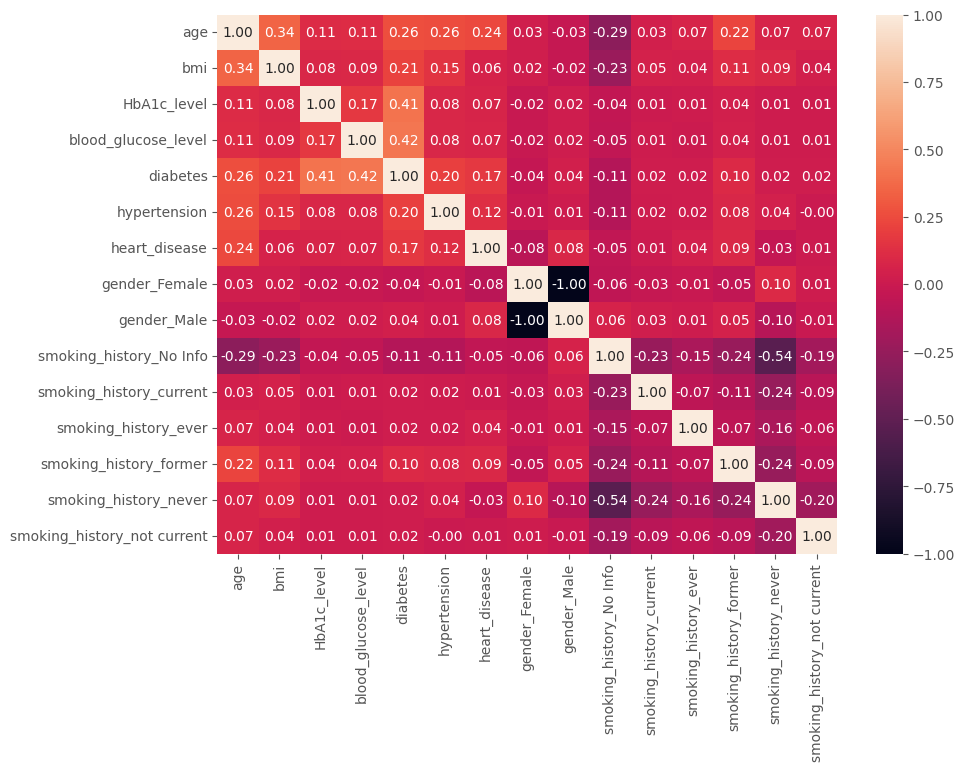

In [36]:
correlation_matrix = df_all_features.corr()
plt.figure(figsize=(10,7))
sns.heatmap(data=correlation_matrix, annot=True, fmt='.2f')

<div>
    <ul>
        <li>
            <code>HbA1c_level</code> is the highest correlated feature with diabetes, confirming what was showes in its boxplot.
        </li>
        <li>
            <code>smoking_history_No info</code> has a large negative correlation with <code>smoking_history_never</code>. This suggests that the <code>No info</code> could possibly mean that the person has no smoking history.
        </li>
        <li>
            For now <code>No info</code> will still be treated as a valid category
        </li>
    </ul>
</div>

<h2 id="umap">Visualizing data with UMAP</h2>

<div>• UMAP, which stands for Uniform Manifold Approximation and Projection, is a powerful dimensionality reduction technique used for visualizing high-dimensional data in a lower-dimensional space. It is particularly effective for preserving both local and global structures of the data, making it a popular choice in machine learning and data analysis.</div>
<div>• We are going to use UMAP to visualize our dataset in a 2D space and look for patterns that can differentiate people with diabtes from those without diabetes</div>
<div>• For this machine learning project I will be using tree-based algorithms. Tree-based methods don't necessarily require feature scaling. So I will not scale the features before applying umap trasnformations.</div>

In [37]:
# The reducer that will project the dataset onto a 2D space
reducer = umap.UMAP(n_jobs=-1,random_state=SEED)

In [38]:
# Unscaled features
df_unscaled_umap = df_all_features.drop(columns='diabetes')

In [39]:
# Embedding the data into the 2D space
embedding = reducer.fit_transform(df_unscaled_umap)

In [41]:
# Creating a dataframe with the embedded data and identifying each instance with its respective diabetes label
df_diabetes_umap = pd.DataFrame(data=embedding,columns=['u0','u1'])
df_diabetes_umap['diabetes'] = df_all_features['diabetes']

<Axes: xlabel='u0', ylabel='u1'>

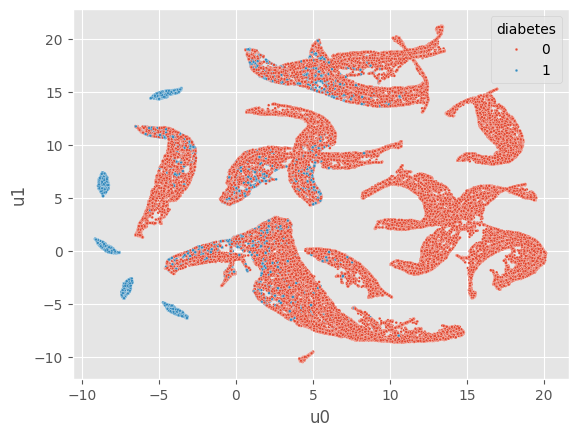

In [42]:
# Plotting the data
sns.scatterplot(data=df_diabetes_umap,x='u0', y='u1', hue='diabetes',s=4)

<div>We can see that there are some cluster with a high density of diabetes (blue dots)</div>

<h1>Model</h1>


<h1>Model Training and Optimization</h1>

<p>In this notebook, I employed the following steps for training and optimizing the machine learning model:</p>

<ol>
  <li><strong>Model Selection:</strong> I chose XGBoost as the machine learning model for predicting diabetes, considering its effectiveness in handling complex relationships in data.</li>
  <br>
  <li><strong>Validation Strategy - Stratified K-fold Cross-Validation:</strong> To ensure robust model evaluation, I employed a Stratified K-fold cross-validation approach. This method maintains the distribution of target classes in each fold, especially important when dealing with imbalanced datasets like ours.</li>
  <br>

  <li><strong>Hyperparameter Optimization with Optuna:</strong> To enhance the model's performance, I utilized Optuna for hyperparameter optimization. Optuna systematically explores hyperparameter spaces to find the optimal set of parameters for the XGBoost model.</li>
  <br>

  <li><strong>Experiment Tracking with MLflow:</strong> I integrated MLflow for experiment tracking. MLflow allows me to log and organize experiments, making it easier to reproduce results and compare different model versions.</li>
  <br>

  <li><strong>Handling Imbalanced Dataset - scale_pos_weight Parameter:</strong> Given the imbalanced nature of the dataset, where the majority class (non-diabetic) significantly outnumbers the minority class (diabetic), I specifically tuned the <code>scale_pos_weight</code> parameter in XGBoost. This parameter helps address class imbalance during training by assigning higher weights to the minority class, allowing the model to better capture patterns related to diabetes.</li>
  <br>
</ol>

<h2>About MLflow</h2>

<p>MLflow is an open-source platform that simplifies the end-to-end machine learning lifecycle. It provides tools for tracking experiments, packaging code into reproducible runs, and sharing and deploying models. By leveraging MLflow, I ensure transparency and reproducibility in my machine learning experiments.</p>

<p>Feel free to explore the MLflow UI to delve deeper into the tracked experiments and compare model performance across different configurations.</p>

<p>The XGBoost model and its optimized hyperparameters will be serialized to be used by the API.</p>


In [71]:
# Variables
X = df.drop(columns=['diabetes'])

# Target
y = df['diabetes']

df.to_parquet("cleaned_diabetes_data.parquet")

In [44]:
# Creating the folds for the k fold cross-validation
kfold = StratifiedKFold(n_splits=5 , shuffle=True, random_state=SEED)

In [46]:
# Create the column transformer to handle the feature transformations
column_transformer = ColumnTransformer(
    [
        ('num','passthrough',num_features),
        ('cat',OrdinalEncoder(),cat_features),
        ('bin','passthrough', bin_features)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

In [47]:
# Function to create a classification pipeline for different models
def create_classification_pipeline(classifier_model):

    pipeline = Pipeline(
        [
            ('transformer',column_transformer),
            ('classifier',classifier_model)
        ]
    )
    return pipeline

In [48]:
def flatten_array(predictions):
    flat_array = []
    for array in predictions:
        for item in array:
            flat_array.append(item)
    return flat_array

<h2>Stratified k-Fold Cross-Validation and Confusion Matrix Construction</h2>

<ul>
  <li>
    <p>In this project, a robust validation strategy, namely stratified k-fold cross-validation, was employed to assess the performance of the machine learning model, ensuring reliable and unbiased evaluation.</p>
  </li>
  <li>
    <p>Stratified k-fold cross-validation is particularly useful when dealing with imbalanced datasets, as it maintains the distribution of the target variable within each fold.</p>
  </li>
  <li>
    <p>The dataset was divided into k (in this case, k=5) folds while preserving the proportion of diabetic and non-diabetic instances in each fold.</p>
  </li>
  <li>
    <p>During each iteration of the cross-validation process, one fold was used as the validation set, and the model was trained on the remaining folds. This process was repeated k times, with each fold serving as the validation set exactly once.</p>
  </li>
  <li>
    <p>The confusion matrix, a crucial evaluation metric for classification models, was constructed using the out-of-fold predictions.</p>
  </li>
  <li>
    <p>For each iteration of the cross-validation, the predictions on the validation set were collected, and a fold-specific confusion matrix was computed.</p>
  </li>
  <li>
    <p>By summing the true positive, false positive, true negative, and false negative values across all folds, an aggregate confusion matrix was obtained, providing a comprehensive overview of the model's performance across different folds.</p>
  </li>
  <li>
    <p>This approach allowed for a thorough assessment of the model's ability to correctly classify instances into true positives, true negatives, false positives, and false negatives.</p>
  </li>
  <li>
    <p>The out-of-fold predictions were also utilized to calculate essential metrics, including accuracy, precision, recall, and ROC AUC.</p>
  </li>
  <li>
    <p>These metrics provide a detailed understanding of the model's overall performance and its ability to correctly identify positive and negative instances.</p>
  </li>
  <li>
    <p>The combination of stratified k-fold cross-validation, aggregated confusion matrix, and comprehensive metric analysis ensures a robust evaluation of the machine learning model's performance on the diabetes prediction task.</p>
  </li>
</ul>


2024/01/12 00:02:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4e42c8ba82cf4fd98be3b14ae7ebd714', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2024/01/12 00:02:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '763589b08e3f4ca3b56d1ccf2dc1f4e1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


X TEST        gender   age  hypertension  heart_disease smoking_history    bmi  \
3      Female  36.0             0              0         current  23.45   
4        Male  76.0             1              1         current  20.14   
10     Female  53.0             0              0           never  27.32   
14     Female  76.0             0              0         No Info  27.32   
21       Male   5.0             0              0         No Info  18.80   
...       ...   ...           ...            ...             ...    ...   
96100    Male  15.0             0              0         No Info  20.98   
96103  Female  51.0             0              0           never  21.49   
96112  Female  61.0             0              0         current  30.11   
96118  Female  23.0             0              0           never  17.87   
96123  Female  36.0             0              0         No Info  24.60   

       HbA1c_level  blood_glucose_level  
3              5.0                  155  
4       

2024/01/12 00:02:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ad8b0dc8ca8b4ae39a2e2435d98f11d2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


X TEST        gender   age  hypertension  heart_disease smoking_history    bmi  \
1      Female  54.0             0              0         No Info  27.32   
12     Female  78.0             0              0          former  36.05   
26       Male  67.0             0              1     not current  27.32   
30     Female  53.0             0              0         No Info  31.75   
31       Male  50.0             0              0         No Info  25.15   
...       ...   ...           ...            ...             ...    ...   
96104  Female  30.0             0              0           never  22.88   
96109    Male  13.0             0              0           never  21.01   
96111    Male  14.0             0              0           never  23.67   
96117  Female  63.0             0              0           never  29.01   
96119    Male  19.0             0              0         No Info  25.75   

       HbA1c_level  blood_glucose_level  
1              6.6                   80  
12      

2024/01/12 00:02:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '26d72277ad8f4a9881268b9618b1f299', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


X TEST        gender   age  hypertension  heart_disease smoking_history    bmi  \
2        Male  28.0             0              0           never  27.32   
5      Female  20.0             0              0           never  27.32   
8        Male  42.0             0              0           never  33.64   
11     Female  54.0             0              0          former  54.70   
15       Male  78.0             0              0         No Info  27.32   
...       ...   ...           ...            ...             ...    ...   
96081    Male  57.0             0              0           never  27.32   
96088    Male  69.0             0              0           never  27.32   
96116    Male  80.0             1              0         No Info  20.96   
96122  Female  40.0             0              0           never  40.69   
96127  Female  57.0             0              0         current  22.43   

       HbA1c_level  blood_glucose_level  
2              5.7                  158  
5       

2024/01/12 00:02:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b7b4b49f7d0a4d6c873657a92b5aa79e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


X TEST        gender   age  hypertension  heart_disease smoking_history    bmi  \
0      Female  80.0             0              1           never  25.19   
6      Female  44.0             0              0           never  19.31   
7      Female  79.0             0              0         No Info  23.86   
9      Female  32.0             0              0           never  27.32   
17     Female  42.0             0              0           never  24.48   
...       ...   ...           ...            ...             ...    ...   
96097    Male  38.0             0              0           never  27.63   
96106  Female  57.0             0              0     not current  31.78   
96108  Female  51.0             0              0           never  29.16   
96115  Female  21.0             0              0         No Info  27.32   
96121  Female  26.0             0              0           never  34.34   

       HbA1c_level  blood_glucose_level  
0              6.6                  140  
6       

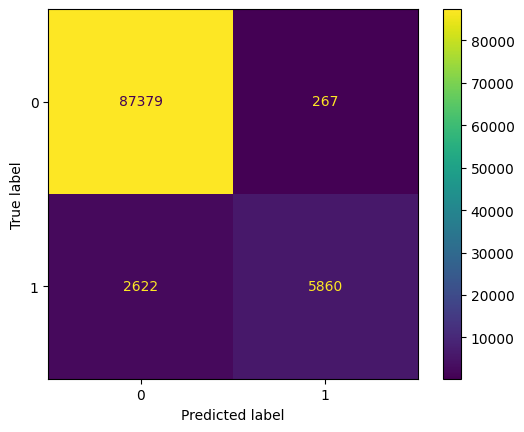

In [64]:
true_positives = []
false_positives = []
true_negatives = []
false_negatives = []
predictions_bin = []
predictions_proba = []
y_true = []
what_is_x=None
for i, (train_index, test_index) in enumerate(kfold.split(X,y)):

    X_train, y_train = X.loc[train_index], y.loc[train_index]
    X_test, y_test = X.loc[test_index], y.loc[test_index]

    classifer_model = XGBClassifier(random_state=SEED)
    
    pipeline_classifier = create_classification_pipeline(classifer_model)

    pipeline_classifier.fit(X_train, y_train)
    
    binary_predictions = pipeline_classifier.predict(X_test)
    proba_predictions = pipeline_classifier.predict_proba(X_test)

    predictions_bin.append(binary_predictions)
    predictions_proba.append(proba_predictions[:,1])
    y_true.append(y_test.to_numpy())

    fold_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=binary_predictions)

    true_positives.append(fold_confusion_matrix[1,1])
    true_negatives.append(fold_confusion_matrix[0,0])
    false_positives.append(fold_confusion_matrix[0,1])
    false_negatives.append(fold_confusion_matrix[1,0])

predictions_bin = flatten_array(predictions_bin)
predictions_proba = flatten_array(predictions_proba)
y_true = flatten_array(y_true)


all_folds_confusion_matrix = np.array(
    [
        [np.sum(true_negatives),np.sum(false_positives)],
        [np.sum(false_negatives),np.sum(true_positives)]
    ]
)


ConfusionMatrixDisplay(all_folds_confusion_matrix).plot()
plt.grid(visible=False)


In [52]:
#Calculating the other metrics
roc_auc_kfold = roc_auc_score(y_true=y_true, y_score=predictions_proba)
accuracy_kfold = accuracy_score(y_true=y_true, y_pred=predictions_bin)
precision_kfold = precision_score(y_true=y_true, y_pred=predictions_bin)
recall_kfold = recall_score(y_true=y_true, y_pred=predictions_bin)

print(roc_auc_kfold)
print(accuracy_kfold)
print(precision_kfold)
print(recall_kfold)


0.9769590168200526
0.9699463215712384
0.9564223926881018
0.6908747936807357


In [53]:
plt.style.use('default')

In [54]:
def objective(trial):

    with mlflow.start_run(nested=True):

        param = {
            "verbosity": 0,

            "objective": "binary:logistic",

            # defines booster, gblinear for linear functions.
            "booster": "gbtree",

            # L2 regularization weight.
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),

            # L1 regularization weight.
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),

            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.5, 1.0,step=0.1),

            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),

            "n_estimators": trial.suggest_int("n_estimators",100,800,step=50),

            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth":trial.suggest_int("max_depth", 2, 8, step=2),

            # minimum child weight, larger the term more conservative the tree.
            'min_child_weight':trial.suggest_int("min_child_weight", 2, 30),

            "eta":trial.suggest_float("eta", 1e-3, 1.0, log=True),

            # defines how selective algorithm is.
            "gamma":trial.suggest_float("gamma", 1e-3, 1.0, log=True),

            "grow_policy":trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),

            "scale_pos_weight":trial.suggest_float("scale_pos_weight",1,10)

        }

        true_positives = []
        false_positives = []
        true_negatives = []
        false_negatives = []
        predictions_bin = []
        predictions_proba = []
        y_true = []

        for i, (train_index, test_index) in enumerate(kfold.split(X,y)):

            X_train, y_train = X.loc[train_index], y.loc[train_index]
            X_test, y_test = X.loc[test_index], y.loc[test_index]

            classifer_model = XGBClassifier(**param, random_state=SEED)
            pipeline_classifier = create_classification_pipeline(classifer_model)

            pipeline_classifier.fit(X_train, y_train)

            binary_predictions = pipeline_classifier.predict(X_test)
            proba_predictions = pipeline_classifier.predict_proba(X_test)

            predictions_bin.append(binary_predictions)
            predictions_proba.append(proba_predictions[:,1])
            y_true.append(y_test.to_numpy())

            fold_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=binary_predictions)

            true_positives.append(fold_confusion_matrix[1,1])
            true_negatives.append(fold_confusion_matrix[0,0])
            false_positives.append(fold_confusion_matrix[0,1])
            false_negatives.append(fold_confusion_matrix[1,0])

        predictions_bin = flatten_array(predictions_bin)
        predictions_proba = flatten_array(predictions_proba)
        y_true = flatten_array(y_true)

        accuracy = accuracy_score(y_true=y_true, y_pred=predictions_bin)
        recall = recall_score(y_true=y_true, y_pred=predictions_bin)
        precision = precision_score(y_true=y_true, y_pred=predictions_bin)
        roc_auc = roc_auc_score(y_true=y_true, y_score=predictions_proba)

        mlflow.log_metric('accuracy',accuracy)
        mlflow.log_metric('recall',recall)
        mlflow.log_metric('precision',precision)
        mlflow.log_metric('roc_auc',roc_auc)
        mlflow.log_param('params',param)

        return roc_auc


In [55]:
study = None
def run_experiments():

    mlflow.set_experiment("XGBoost_tuning_final_version")

    with mlflow.start_run(nested=True) as parent_run:
        mlflow.autolog(log_models=True)
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=50)

        print("Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial

        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))    

run_experiments()


2024/01/11 22:51:48 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost_tuning_final_version' does not exist. Creating a new experiment.
2024/01/11 22:51:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/01/11 22:51:55 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/01/11 22:51:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
[I 2024-01-11 22:51:55,081] A new study created in memory with name: no-name-1e5d65ed-4223-40a3-aba0-39e9f4c47412
[I 2024-01-11 22:52:10,209] Trial 0 finished with value: 0.9653901725889321 and parameters: {'reg_lambda': 0.00013357193572355176, 'reg_alpha': 0.0029692747139117783, 'subsample': 1.0, 'colsample_bytree': 0.8602192683892731, 'n_estimators': 300, 'max_depth': 8, 'min_child_weight': 14, 'eta': 0.8379486662106966, '

Number of finished trials:  50
Best trial:
  Value: 0.9794442155931518
  Params: 
    reg_lambda: 0.20042040698349725
    reg_alpha: 0.4457076330801733
    subsample: 0.7
    colsample_bytree: 0.8912744682027467
    n_estimators: 550
    max_depth: 2
    min_child_weight: 27
    eta: 0.06149639487539178
    gamma: 0.0881818174148695
    grow_policy: depthwise
    scale_pos_weight: 4.173467538920495


In [56]:
# Best parameters found by optuna
best_params = {
    'reg_lambda':0.014057361434063637,
    'reg_alpha': 0.22951318777936996,
    'subsample': 0.6,
    'colsample_bytree': 0.46378802170916145,
    'n_estimators': 700,
    'max_depth': 2,
    'min_child_weight': 20,
    'eta': 0.0591333795386007,
    'gamma': 0.05038154194714027,
    'grow_policy': 'lossguide',
    'scale_pos_weight': 6.512068708260342
}


In [57]:
final_model = XGBClassifier(**best_params, random_state=SEED)

final_pipeline_classifier = create_classification_pipeline(final_model)

final_pipeline_classifier.fit(X, y)


2024/01/11 23:58:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e99eefe1c63646549a106b42af7fb90b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'bmi', 'HbA1c_level',
                                                   'blood_glucose_level']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['gender',
                                                   'smoking_history']),
                                                 ('bin', 'passthrough',
                                                  ['hypertension',
                                                   'heart_disease'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsampl...
                               gamma=0.05038154194714027,
                               grow_policy='lossguide', importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=20, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=700, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [58]:
final_classifier = final_pipeline_classifier[-1]
final_transformer = final_pipeline_classifier[0]

<p>The feature importances show what was already noted during the EDA: the features related to blood glucose levels are the ones with more predicting power.</p>

In [59]:
dict_feature_importances = {'feature':final_transformer.get_feature_names_out(), 'importance':final_classifier.feature_importances_}
df_feature_importances = pd.DataFrame.from_dict(dict_feature_importances).sort_values(by='importance',ascending=False)
df_feature_importances

,feature,importance
2,num__HbA1c_level,0.447594
3,num__blood_glucose_level,0.272720
0,num__age,0.110544
6,bin__hypertension,0.063809
1,num__bmi,0.041686
7,bin__heart_disease,0.036630
5,cat__smoking_history,0.017611
4,cat__gender,0.009406


<h2>Serializing the model</h2>

In [66]:
# Serializing the model so it can be used with the API
with open('diabetes_model.pkl','wb') as model:
    pickle.dump(final_pipeline_classifier,model)

<class 'pandas.core.frame.DataFrame'>
Index: 19225 entries, 13 to 96126
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               19225 non-null  object 
 1   age                  19225 non-null  float64
 2   hypertension         19225 non-null  int64  
 3   heart_disease        19225 non-null  int64  
 4   smoking_history      19225 non-null  object 
 5   bmi                  19225 non-null  float64
 6   HbA1c_level          19225 non-null  float64
 7   blood_glucose_level  19225 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 1.3+ MB
